
# Compute envelope correlations in volume source space

Compute envelope correlations of orthogonalized activity
:footcite:`HippEtAl2012,KhanEtAl2018` in source space using resting state
CTF data in a volume source space.


In [1]:
# Authors: Eric Larson <larson.eric.d@gmail.com>
#          Sheraz Khan <sheraz@khansheraz.com>
#          Denis Engemann <denis.engemann@gmail.com>
#
# License: BSD (3-clause)

import os.path as op

import mne
import mne_connectivity
from mne.beamformer import make_lcmv, apply_lcmv_epochs
from mne.preprocessing import compute_proj_ecg, compute_proj_eog
from mne_connectivity import envelope_correlation

data_path = mne.datasets.brainstorm.bst_resting.data_path()
subjects_dir = op.join(data_path, "subjects")
subject = "bst_resting"
trans = op.join(data_path, "MEG", "bst_resting", "bst_resting-trans.fif")
bem = op.join(subjects_dir, subject, "bem", subject + "-5120-bem-sol.fif")
raw_fname = op.join(
    data_path, "MEG", "bst_resting", "subj002_spontaneous_20111102_01_AUX.ds"
)
crop_to = 60.0

Here we do some things in the name of speed, such as crop (which will
hurt SNR) and downsample. Then we compute SSP projectors and apply them.



In [2]:
raw = mne.io.read_raw_ctf(raw_fname, verbose="error")
raw.crop(0, crop_to).pick_types(meg=True, eeg=False).load_data().resample(80)
raw.apply_gradient_compensation(3)
projs_ecg, _ = compute_proj_ecg(raw, n_grad=1, n_mag=2)
projs_eog, _ = compute_proj_eog(raw, n_grad=1, n_mag=2, ch_name="MLT31-4407")
raw.add_proj(projs_ecg + projs_eog)
raw.apply_proj()
cov = mne.compute_raw_covariance(raw)  # compute before band-pass of interest

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Reading 0 ... 144000  =      0.000 ...    60.000 secs...
Including 0 SSP projectors from raw file
Running ECG SSP computation
Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 800 samples (10.000 s)

Number of ECG events detected : 88 (average pulse 88 / min.)
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, no

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s


Adding projection: axial--0.200-0.400-PCA-02 (exp var=22.8%)
No channels 'eeg' found. Skipping.
Done.
Including 0 SSP projectors from raw file
Running EOG SSP computation
Using EOG channel: MLT31-4407
EOG channel index for this subject is: [137]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel MLT31-4407 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 800 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 12 significant peaks
Number of EOG events detected: 12
Computing projector
Fil

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s


Adding projection: axial--0.200-0.200-PCA-01 (exp var=92.2%)
Adding projection: axial--0.200-0.200-PCA-02 (exp var=2.4%)
No channels 'eeg' found. Skipping.
Done.
4 projection items deactivated
Created an SSP operator (subspace dimension = 4)
4 projection items activated
SSP projectors applied...
Using up to 300 segments
Number of samples used : 4800
[done]


Now we band-pass filter our data and create epochs.



In [3]:
raw.filter(14, 30)
events = mne.make_fixed_length_events(raw, duration=5.0)
epochs = mne.Epochs(
    raw,
    events=events,
    tmin=0,
    tmax=5.0,
    baseline=None,
    reject=dict(mag=8e-13),
    preload=True,
)
data_cov = mne.compute_covariance(epochs)
del raw, projs_ecg, projs_eog

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 12.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 77 samples (0.963 s)

Not setting metadata
12 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 12 events and 401 original time points ...
    Rejecting  epoch based on MAG : ['MRC42-4407', 'MRC54-4407', 'MRP12-4407', 'MRP22-4407', 'MRP23-4407']
2 bad epochs dropped
Removing 5 compensators from info because not all compensation channels were p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s


    Created an SSP operator (subspace dimension = 4)
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 272 -> 268
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 4010
[done]


## Compute the forward and inverse



In [4]:
# This source space is really far too coarse, but we do this for speed
# considerations here
pos = 15.0  # 1.5 cm is very broad, done here for speed!
src = mne.setup_volume_source_space(
    "bst_resting", pos, bem=bem, subjects_dir=subjects_dir, verbose=True
)
fwd = mne.make_forward_solution(epochs.info, trans, src, bem)
filters = make_lcmv(
    epochs.info, fwd, data_cov, 0.05, cov, pick_ori="max-power", weight_norm="nai"
)

BEM              : /Users/siddharthsrivastava/mne_data/MNE-brainstorm-data/bst_resting/subjects/bst_resting/bem/bst_resting-5120-bem-sol.fif
grid                  : 15.0 mm
mindist               : 5.0 mm
MRI volume            : /Users/siddharthsrivastava/mne_data/MNE-brainstorm-data/bst_resting/subjects/bst_resting/mri/T1.mgz

Reading /Users/siddharthsrivastava/mne_data/MNE-brainstorm-data/bst_resting/subjects/bst_resting/mri/T1.mgz...

Loaded inner skull from /Users/siddharthsrivastava/mne_data/MNE-brainstorm-data/bst_resting/subjects/bst_resting/bem/bst_resting-5120-bem-sol.fif (2562 nodes)
Surface CM = (   3.1  -22.2   29.7) mm
Surface fits inside a sphere with radius  105.3 mm
Surface extent:
    x =  -71.2 ...   75.4 mm
    y = -110.1 ...   82.9 mm
    z =  -48.4 ...   98.1 mm
Grid extent:
    x =  -75.0 ...   90.0 mm
    y = -120.0 ...   90.0 mm
    z =  -60.0 ...  105.0 mm
2160 sources before omitting any.
1364 sources after omitting infeasible sources not within 0.0 - 105.3 mm.

## Compute label time series and do envelope correlation



In [5]:
epochs.apply_hilbert()  # faster to do in sensor space
stcs = apply_lcmv_epochs(epochs, filters, return_generator=True)
corr = envelope_correlation(stcs, verbose=True)
del stcs, epochs, filters

# average over epochs
corr = corr.combine()

Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
[done]


## Compute the degree and plot it



Transforming subject RAS (non-zero origin) -> MNI Talairach
    1.029906 0.008134 -0.048341      -1.23 mm
    0.013579 0.955254 0.160974      -9.34 mm
    0.075120 -0.143988 1.092494     -28.73 mm
    0.000000 0.000000 0.000000       1.00

Showing: t = 0.000 s, (43.2, -61.2, 16.1) mm, [8, 4, 6] vox, 1136 vertex
Using control points [ 82.5  92.3 107. ]


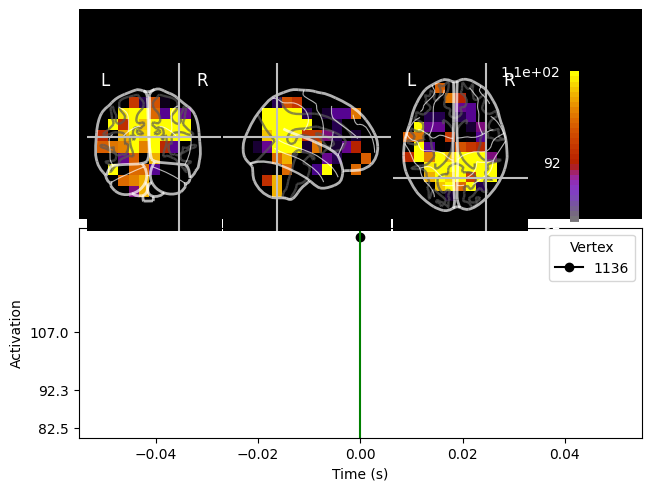

In [6]:
degree = mne_connectivity.degree(corr, 0.15)
stc = mne.VolSourceEstimate(degree, [src[0]["vertno"]], 0, 1, "bst_resting")
brain = stc.plot(
    src,
    clim=dict(kind="percent", lims=[75, 85, 95]),
    colormap="gnuplot",
    subjects_dir=subjects_dir,
    mode="glass_brain",
)

## References
.. footbibliography::